In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pyquil.api as api
from pyquil.gates import *
from pyquil.quil import Program

First, let's write a function that returns a list of all the possible bit-strings in increasing lexicographical order that one can obtain from measuring $n$ qubits.

In [2]:
def qubit_strings(n):
    qubit_strings = []
    for q in itertools.product(['0', '1'], repeat=n):
        qubit_strings.append(''.join(q))
    return qubit_strings

In [3]:
assert qubit_strings(3) == ['000', '001', '010', '011', '100', '101', '110', '111']

Next, let's construct the black-box map $f:\{0, 1\}^n \rightarrow \{0, 1\}$ that outputs 1 when the input is the $n$-bitstring to be found, and 0 otherwise.

In [4]:
def black_box_map(n, q_find):
    """
    Black-box map, f(x), on n qubits such that f(q_find) = 1, and otherwise = 0
    
    :return: dict implementing the black-box map
    """
    assert n == len(q_find)
    qubs = qubit_strings(n)
    d_blackbox = {q: 1 if q == q_find else 0 for q in qubs}
    return d_blackbox

In [5]:
assert black_box_map(3, '001') == {'000': 0, '001': 1, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}

Given an input $n$-bitstring, write a function that will create a ket as a numpy array of shape $(2^n,)$<br> (Hint: numpy.kron is your friend here)

In [6]:
def qubit_ket(qub_string):
    """
    Form a basis ket out of n-bit string specified by the input 'qub_string', e.g.
    '001' -> |001>
    
    :return: numpy array of shape (2^n,) , where n is the length of the input bit-string
    """
    e0 = np.array([1, 0])
    e1 = np.array([0, 1])
    d_qubstring = {'0': e0, '1': e1}

    # initialize ket
    ket = d_qubstring[qub_string[0]]
    for i in range(1, len(qub_string)):
        ket = np.kron(ket, d_qubstring[qub_string[i]])
    
    return ket

In [7]:
np.testing.assert_array_equal(qubit_ket('01'), np.array([0, 1, 0, 0]))

In [8]:
assert qubit_ket('0101').shape == (2**4,)
assert qubit_ket('110101').shape == (2**6,)

Given an input $n$-bitstring, write a function that will create a projection operator as a numpy array of shape $(2^n, 2^n)$<br> (Hint: numpy.kron is your friend here)

In [9]:
def projection_op(qub_string):
    """
    Creates a projection operator out of the basis element specified by 'qub_string', e.g.
    '101' -> |101> <101|
    
    :return: numpy array of shape (2^n, 2^n), where n is the length of the input bit-string
    """
    ket = qubit_ket(qub_string)
    proj = np.outer(ket, ket)   # all entries real, so no complex conjugation necessary
    return proj

In [10]:
np.testing.assert_array_equal(projection_op('01'), np.array([[0, 0, 0, 0],
                                                             [0, 1, 0, 0],
                                                             [0, 0, 0, 0],
                                                             [0, 0, 0, 0]]))

In [11]:
assert projection_op('101').shape == (2**3, 2**3)
assert projection_op('1011010').shape == (2**7, 2**7)

Construct the unitary representation of the black box operator. Note that the quantum black box that achieves the transformation<br>
<br>
$$U_{f(\vec{x})} \left\vert \vec{x} \right\rangle \left\vert y \right\rangle = \left\vert \vec{x} \right\rangle \left\vert y \oplus f(\vec{x}) \right\rangle$$
<br>
can be written in the following explicit form <br>
<br>
$$U_{f(\vec{x})} = \sum_{\vec{x} = 0}^{2^{n} - 1} \left\vert \vec{x} \right\rangle \left\langle \vec{x} \right\vert \otimes \left[ I + f(\vec{x}) [X - I]\right]$$

In [12]:
def black_box(n, q_find):
    """
    Unitary representation of the black-box operator on (n+1)-qubits
    
    :return: numpy array of shape (2^(n+1), 2^(n+1))
    """
    d_bb = black_box_map(n, q_find)
    # initialize unitary matrix
    N = 2**(n+1)
    unitary_rep = np.zeros(shape=(N, N))
    # populate unitary matrix
    for k, v in d_bb.items():
        unitary_rep += np.kron(projection_op(k), np.eye(2) + v*(-np.eye(2) + np.array([[0, 1], [1, 0]])))
    return unitary_rep

In [13]:
# black_box(2, '01')
np.testing.assert_array_equal(black_box(2, '01'), np.array([[1., 0., 0., 0., 0., 0., 0., 0.],
                                                            [0., 1., 0., 0., 0., 0., 0., 0.],
                                                            [0., 0., 0., 1., 0., 0., 0., 0.],
                                                            [0., 0., 1., 0., 0., 0., 0., 0.],
                                                            [0., 0., 0., 0., 1., 0., 0., 0.],
                                                            [0., 0., 0., 0., 0., 1., 0., 0.],
                                                            [0., 0., 0., 0., 0., 0., 1., 0.],
                                                            [0., 0., 0., 0., 0., 0., 0., 1.]]))

In [14]:
assert black_box(7, '1011010').shape == (2**(7+1), 2**(7+1))

Construct the Grover operator $2 \vert \psi \rangle \langle \psi \vert - I$, where $\vert \psi \rangle = H^{\otimes n} \vert 0 \rangle$.

In [15]:
def grov_op(n):
    """
    The operator 2|psi><psi| - I , where |psi> = H^n |0>
    
    :return: numpy array of shape (2^n, 2^n)
    """
    qubs = qubit_strings(n)
    N = 2**n
    proj_psipsi = np.zeros(shape=(N, N))
    for s_ket in qubs:
        ket = qubit_ket(s_ket)
        for s_bra in qubs:
            bra = qubit_ket(s_bra)
            proj_psipsi += np.outer(ket, bra)
    # add normalization factor
    proj_psipsi *= 1/N

    return 2*proj_psipsi - np.eye(N)

In [16]:
np.testing.assert_array_equal(grov_op(2), np.array([[-0.5,  0.5,  0.5,  0.5],
                                                   [ 0.5, -0.5,  0.5,  0.5],
                                                   [ 0.5,  0.5, -0.5,  0.5],
                                                   [ 0.5,  0.5,  0.5, -0.5]]))

In [17]:
assert grov_op(4).shape == (2**4, 2**4)

Apply Grover's algorithm to search a bitstring.

In [18]:
# Specify an item to find
findme = '1011'

The most probable outcome is: |1011>


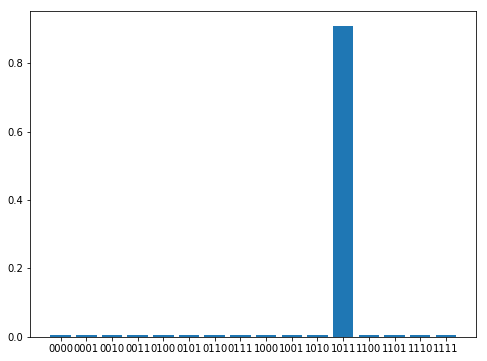

In [19]:
# number of qubits (excluding the ancilla)
n = len(findme)
# number of iterations
num_iters = max(1, int(np.sqrt(2**(n-2))))

p = Program()
# define blackbox operator (see above) 
p.defgate("U_bb", black_box(n, findme))
# define the U_grov (see above)
p.defgate("U_grov", grov_op(n))
# Apply equal superposition state
for q in range(1, n+1):
    p.inst(H(q))
# Make 0th qubit an eigenstate of the black-box operator, i.e.
# create the state 1/(sqrt(2)) * (|0> - |1>) on the 0th qubit
p.inst(H(0))
p.inst(Z(0))
    
# Grover iterations
for _ in range(num_iters):
    # apply oracle
    p.inst(("U_bb",) + tuple(range(n+1)[::-1]))
    # apply H . U_perp . H
    p.inst(("U_grov",) + tuple(range(1, n+1)[::-1]))
    
# measure and discard ancilla
p.measure(0)
    
# run program, and investigate wavefunction
qvm = api.WavefunctionSimulator()
wavefunc = qvm.wavefunction(p)
outcome_probs = wavefunc.get_outcome_probs()
print ("The most probable outcome is: |%s>" % (max(outcome_probs, key=outcome_probs.get)[:-1]))

# histogram of outcome probs
plt.figure(figsize=(8, 6))
plt.bar([i[:-1] for i in outcome_probs.keys()], outcome_probs.values())
plt.show()